In [1]:
# For library input
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
import statsmodels.api as sm
import numpy as np

In [2]:
#Read CSV
data = pd.read_csv('full_data_20200920.csv')

In [3]:
# Check if there is missed value
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190794 entries, 0 to 190793
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Unnamed: 0                   190794 non-null  int64 
 1   Project Name                 190794 non-null  object
 2   Address                      190794 non-null  object
 3   No. of Units                 190794 non-null  int64 
 4   Area (sqm)                   190794 non-null  int64 
 5   Type of Area                 190794 non-null  object
 6   Transacted Price ($)         190794 non-null  int64 
 7   Nett Price($)                190794 non-null  object
 8   Unit Price ($ psm)           190794 non-null  int64 
 9   Unit Price ($ psf)           190794 non-null  int64 
 10  Sale Date                    190794 non-null  object
 11  Property Type                190794 non-null  object
 12  Tenure                       190794 non-null  object
 13  Completion Dat

### Exploratory Data Analysis on Private Property

In [4]:
# Show number of transcations in each distrcit
Trans_by_district = pd.DataFrame(data['Postal District'].value_counts().sort_values())
Trans_by_district

,Postal District
6,23
26,1054
25,1795
7,1917
1,2432
2,2503
8,2703
4,3003
17,4281
22,4718


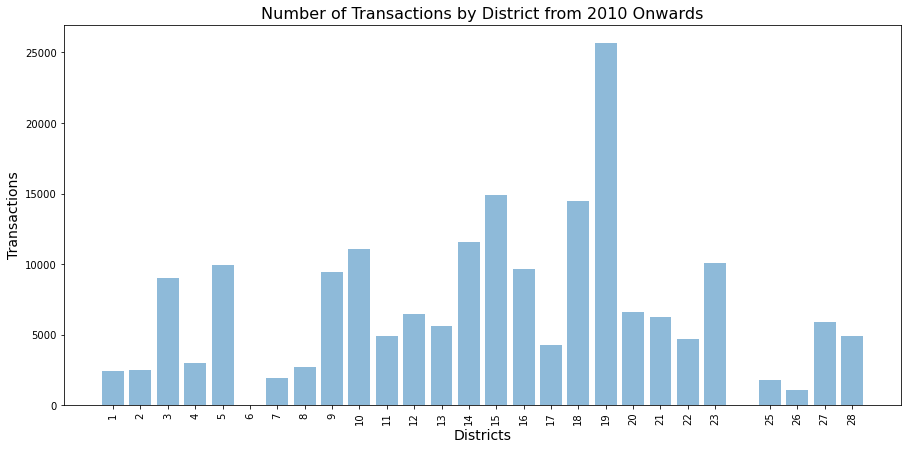

In [5]:
#Histogram to plot number of transcations in each distrcit
plt.figure(figsize=(15,7))
plt.bar(list(Trans_by_district.index), Trans_by_district['Postal District'], align='center', alpha=0.5)
plt.xlabel('Districts', fontsize=14)
plt.xticks(list(Trans_by_district.index),rotation=90)
plt.ylabel('Transactions', fontsize=14)
plt.title('Number of Transactions by District from 2010 Onwards', fontsize=16)

plt.show()

### Box plot

In [6]:
#Amend the column of Sales Date into a datetime object (month_year)
data['Month_Year'] = pd.to_datetime(data['Sale Date']).dt.to_period('M')

#Drop the first column (Unnamed: 0)
data = data.drop('Unnamed: 0', axis=1)

Text(0.5, 1.0, 'Distribution of Price psf from 2019 Onwards')

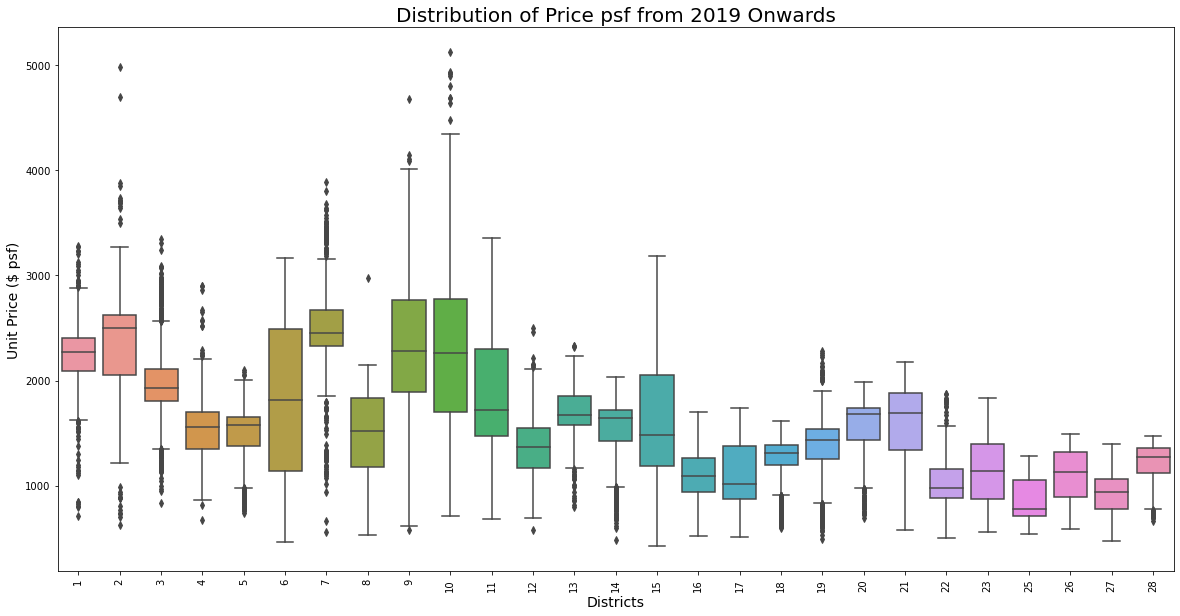

In [7]:
data_temp = data.loc[data['Month_Year'] > '2018-12']
data_temp['Month_Year']

plt.figure(figsize=(20,10))
sns.boxplot( x = data_temp['Postal District'], y = data_temp['Unit Price ($ psf)'], data=data)
plt.xlabel('Districts', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Unit Price ($ psf)', fontsize=14)
plt.title('Distribution of Price psf from 2019 Onwards', fontsize=20)

#### We can see that District location could be a critical factor which determines the property price.

#### Data Pre-processing and ARIMA

In [8]:
#Average_monthly for each district
Average_monthly = data.groupby(['Postal District', 'Month_Year'], as_index=False)['Unit Price ($ psf)'].mean()
Average_monthly_df = pd.DataFrame(Average_monthly)

In [9]:
Average_monthly_df.info()
Average_monthly_df['Postal District'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3154 entries, 0 to 3153
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   Postal District     3154 non-null   int64    
 1   Month_Year          3154 non-null   period[M]
 2   Unit Price ($ psf)  3154 non-null   float64  
dtypes: float64(1), int64(1), period[M](1)
memory usage: 98.6 KB


27    121
3     121
4     121
8     121
10    121
12    121
14    121
16    121
18    121
20    121
22    121
28    121
1     121
5     121
9     121
11    121
13    121
15    121
17    121
19    121
21    121
23    121
2     121
25    120
26    120
7     116
6      15
Name: Postal District, dtype: int64

#### Our dataset period is from 2010-Sep to 2020-Sep, so there should be 121 datapoints.
#### District 6 has too little datapoint so we drop the analysis on district 6 
#### For district 25,26, and 7, they have 116 and 120 points, therefore we will assume the missing monthly price is the same as previous monthly price 

In [10]:
# Drop District 6
Average_monthly_df_drop = Average_monthly_df[Average_monthly_df['Postal District'] != 6]

#Input missing datapoint
# make it as a pivot table
pivot = Average_monthly_df_drop.pivot(index='Month_Year', columns = 'Postal District', values = 'Unit Price ($ psf)')
#Fill in missing values
pivot.fillna(method='ffill', inplace=True)
#Back to an array
Average_monthly_df_filled = pivot.stack().reset_index()
Average_monthly_df_filled.sort_values(['Postal District', 'Month_Year'])
#To check
Average_monthly_df_filled['Postal District'].value_counts()

27    121
25    121
4     121
8     121
10    121
12    121
14    121
16    121
18    121
20    121
22    121
26    121
28    121
1     121
3     121
5     121
7     121
9     121
11    121
13    121
15    121
17    121
19    121
21    121
23    121
2     121
Name: Postal District, dtype: int64

In [11]:
Average_monthly_df_filled.rename(columns={0: "Unit Price ($ psf)"}, inplace=True)
Average_monthly_df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146 entries, 0 to 3145
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   Month_Year          3146 non-null   period[M]
 1   Postal District     3146 non-null   int64    
 2   Unit Price ($ psf)  3146 non-null   float64  
dtypes: float64(1), int64(1), period[M](1)
memory usage: 73.9 KB


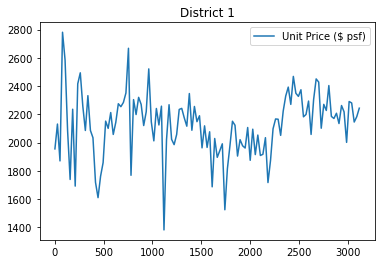

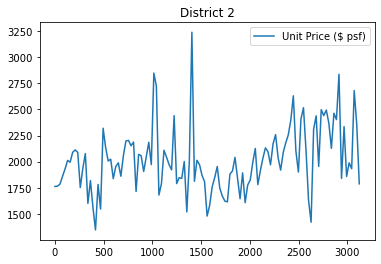

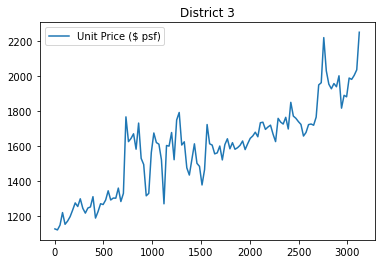

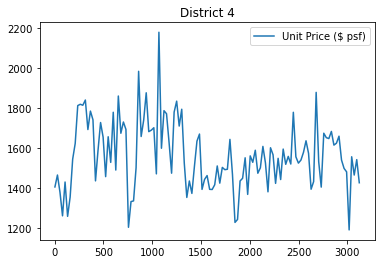

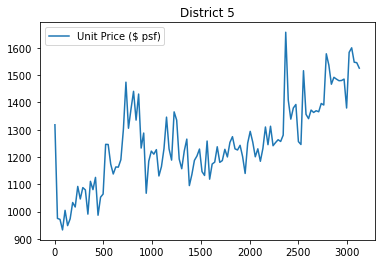

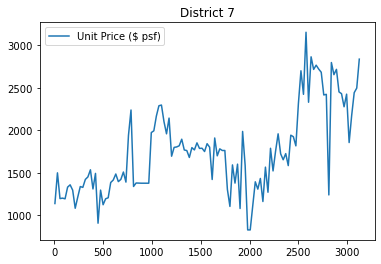

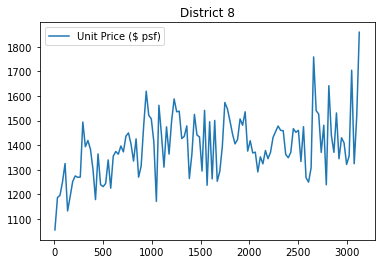

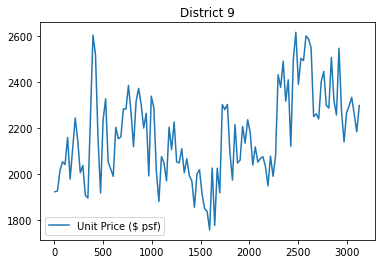

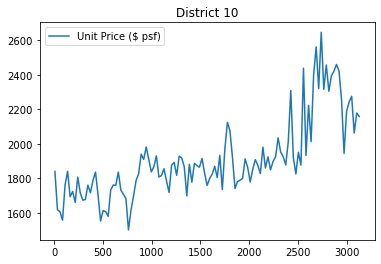

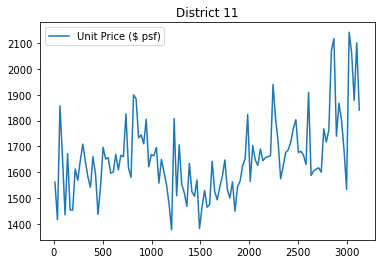

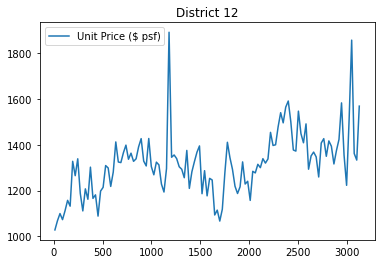

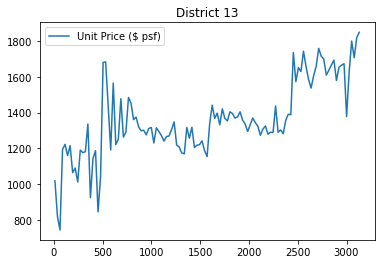

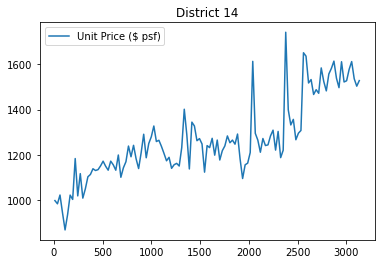

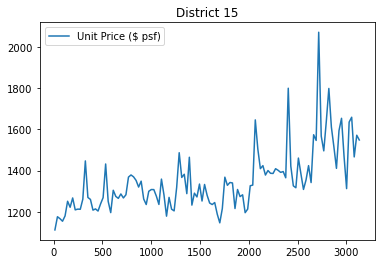

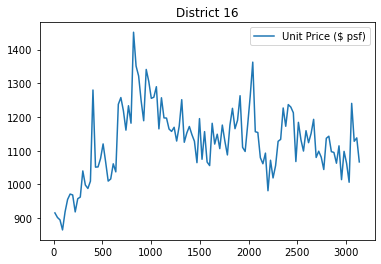

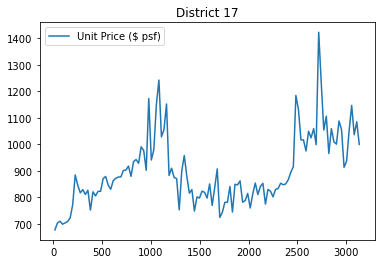

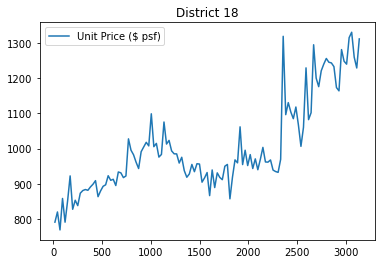

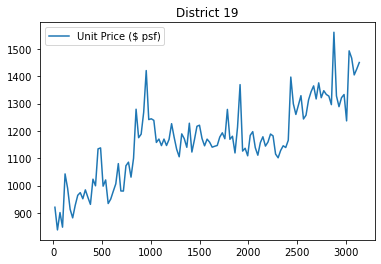

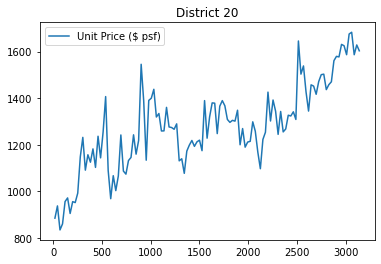

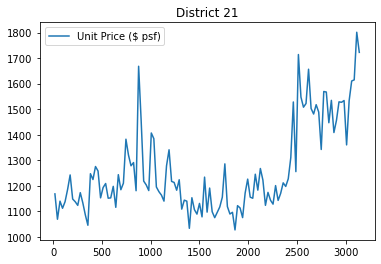

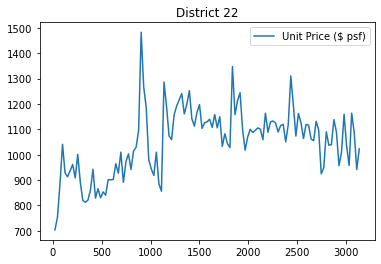

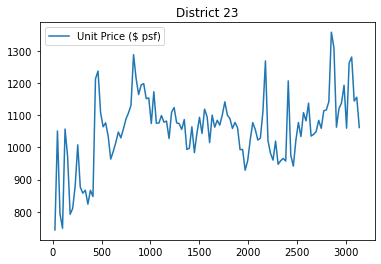

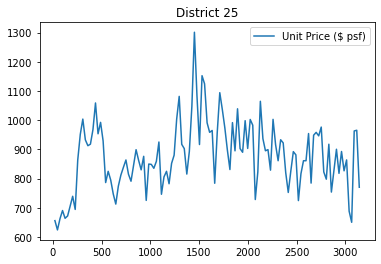

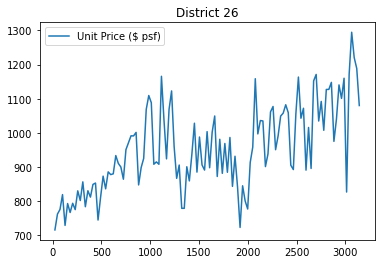

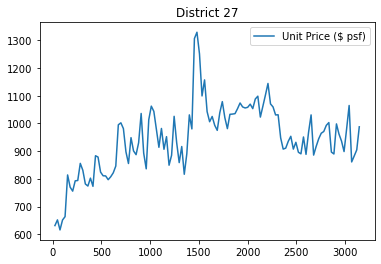

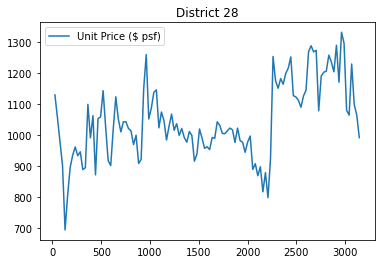

In [12]:
# Plot monthly average unit price for each district for past ten years
for i in [x for x in range(1,29) if x != 6 and x !=24]:
    Average_monthly_df_filled.loc[(Average_monthly_df_filled['Postal District'] == i)].plot(y='Unit Price ($ psf)')
    plt.title('District ' + str(i))
    plt.show()

#### Take log on Unit Price ($ psf)

In [13]:
#Add a column to store log_psf
Average_monthly_df_filled.loc[ : , 'log_psf'] = np.log(Average_monthly_df_filled['Unit Price ($ psf)'])
Average_monthly_df_filled.head()

,Month_Year,Postal District,Unit Price ($ psf),log_psf
0,2010-09,1,1955.500000,7.578401
1,2010-09,2,1762.523810,7.474502
2,2010-09,3,1129.108696,7.029184
3,2010-09,4,1404.771429,7.247630
4,2010-09,5,1318.385027,7.184163


#### Utilize ARIMA model and forecast for each district

In [14]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from math import e

In [15]:
import numpy as np
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [16]:
# Print model summaries, plots, and prediction results for all districts except Distrct 6 & 24
districts = []
MAPE = []
percentage_change = []
log_Predicted = []
log_Currentprice = []
for i in [x for x in range(1,29) if x != 6 and x !=24]:
        print('=============================Results of District', i,'============================')
        # train the model
        train_size = round(0.9 * len(Average_monthly_df_filled[(Average_monthly_df_filled['Postal District'] == i)]))
        test_size = round(0.1 * len(Average_monthly_df_filled[(Average_monthly_df_filled['Postal District'] == i)]))
        train = Average_monthly_df_filled[(Average_monthly_df_filled['Postal District'] == i)][:train_size]
        test = Average_monthly_df_filled[(Average_monthly_df_filled['Postal District'] == i)][train_size:]
        
        if len(train) >= 50:
            model = pm.auto_arima(train[(train['Postal District'] == i)]['log_psf'], suppress_warnings=True)
            #print(model.summary())
            temp = model.order
            p, d, q = temp[0], temp[1], temp[2]
            #print(model.plot_diagnostics())
            
            #model.resid()
            #plot_acf(model.resid(),lags=20)
            #plt.show()
            #plot_pacf(model.resid(),lags=20)
            #plt.show()
            
            pred = model.predict(test_size)
            Test = pd.DataFrame()
            Test['pred'] = list(pred)
            MAPE_ij = mape(list(test['log_psf']), Test['pred'])
            
            model_p = pm.auto_arima(Average_monthly_df_filled[(Average_monthly_df_filled['Postal District'] == i)]['log_psf'],suppress_warnings=True)
            #model_p = ARIMA(Average_monthly_df[(Average_monthly_df['Postal District'] == i)&(Average_monthly_df['Tenure_dummy(>900)'] == j)]['log_psf'],order=(p, d, q))
            pred_p = model_p.predict(36)
            print(model_p.summary())
            print()
            # integrate the results
            districts.append(i)
            MAPE.append(MAPE_ij)
            percentage_change.append(float(100*(pred_p[-1:] - float(Average_monthly_df_filled[(Average_monthly_df_filled['Postal District'] == i)]['log_psf'][-1:]))))
            log_Predicted.append(float(pred_p[-1:]))
            log_Currentprice.append(float(Average_monthly_df_filled[(Average_monthly_df_filled['Postal District'] == i)]['log_psf'][-1:]))
                           
        else:
            pass

=============================Results of District 1 ============================
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 105.976
Date:                Sun, 04 Oct 2020   AIC                           -203.952
Time:                        21:00:39   BIC                           -192.769
Sample:                             0   HQIC                          -199.410
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4818      1.535      1.617      0.106      -0.526       5.490
ar.L1          0.6757      0.200      3.370      0.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  36.729
Date:                Sun, 04 Oct 2020   AIC                            -69.458
Time:                        21:00:57   BIC                            -63.883
Sample:                             0   HQIC                           -67.194
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5800      0.058     -9.950      0.000      -0.694      -0.466
sigma2         0.0316      0.003     11.808      0.000       0.026       0.037
Ljung-Box (Q):                       32.31   Jarque-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 136.967
Date:                Sun, 04 Oct 2020   AIC                           -267.935
Time:                        21:01:21   BIC                           -259.572
Sample:                             0   HQIC                          -264.539
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5030      0.074     -6.803      0.000      -0.648      -0.358
ma.L2         -0.2232      0.090     -2.488      0.013      -0.399      -0.047
sigma2         0.0059      0.001     11.475      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 133.732
Date:                Sun, 04 Oct 2020   AIC                           -259.463
Time:                        21:01:42   BIC                           -248.313
Sample:                             0   HQIC                          -254.935
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8780      0.074    -11.888      0.000      -1.023      -0.733
ma.L1          0.4301      0.096      4.490      0.000       0.242       0.618
ma.L2         -0.5328      0.073     -7.275      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 127.931
Date:                Sun, 04 Oct 2020   AIC                           -249.862
Time:                        21:01:59   BIC                           -241.500
Sample:                             0   HQIC                          -246.466
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3572      0.098     -3.634      0.000      -0.550      -0.165
ma.L2         -0.3833      0.100     -3.835      0.000      -0.579      -0.187
sigma2         0.0069      0.001     11.679      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 136.384
Date:                Sun, 04 Oct 2020   AIC                           -266.768
Time:                        21:02:26   BIC                           -258.406
Sample:                             0   HQIC                          -263.372
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6429      0.102      6.333      0.000       0.444       0.842
ma.L1         -0.9283      0.051    -18.116      0.000      -1.029      -0.828
sigma2         0.0060      0.001     10.241      0.0

#### The Result table

In [17]:
Result_1 = pd.DataFrame({'district': districts, 'MAPE': MAPE, 'log_Predicted': log_Predicted, 'log_Currentprice': log_Currentprice})
Result_1['Predicted'] = np.exp(Result_1['log_Predicted'])
Result_1['Currentprice'] = np.exp(Result_1['log_Currentprice'])
Result_1['percentage_increase'] = Result_1['Predicted'] / Result_1['Currentprice'] - 1
Result_1.sort_values('percentage_increase', ascending=False)

,district,MAPE,log_Predicted,log_Currentprice,Predicted,Currentprice,percentage_increase
18,20,0.710170,7.577187,7.380002,1953.127327,1603.592593,0.217970
1,2,1.846413,7.675950,7.488453,2155.871823,1787.285714,0.206227
12,14,0.410972,7.498114,7.331785,1804.635319,1528.107143,0.180961
23,26,1.170766,7.147431,6.984716,1270.836826,1080.000000,0.176701
16,18,0.441463,7.303875,7.179381,1486.046496,1312.095238,0.132575
25,28,1.046103,7.024037,6.900328,1123.312170,992.600000,0.131687
17,19,0.715485,7.402667,7.279652,1640.353697,1450.483146,0.130902
4,5,0.395657,7.450505,7.330332,1720.731237,1525.888889,0.127691
22,25,1.685449,6.756545,6.646391,859.666818,770.000000,0.116450
11,13,0.703470,7.624110,7.522610,2046.956892,1849.387755,0.106829


### Now we want to want to focus on 'resale' property market

In [18]:
#Check the values in feature ['Type of Sale']
data['Type of Sale'].unique()

array(['Resale', 'New Sale'], dtype=object)

In [19]:
#Subset the data
data_resale = data[data['Type of Sale']=='Resale']
data_resale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82389 entries, 0 to 190793
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype    
---  ------                       --------------  -----    
 0   Project Name                 82389 non-null  object   
 1   Address                      82389 non-null  object   
 2   No. of Units                 82389 non-null  int64    
 3   Area (sqm)                   82389 non-null  int64    
 4   Type of Area                 82389 non-null  object   
 5   Transacted Price ($)         82389 non-null  int64    
 6   Nett Price($)                82389 non-null  object   
 7   Unit Price ($ psm)           82389 non-null  int64    
 8   Unit Price ($ psf)           82389 non-null  int64    
 9   Sale Date                    82389 non-null  object   
 10  Property Type                82389 non-null  object   
 11  Tenure                       82389 non-null  object   
 12  Completion Date              82389 non-null  

In [20]:
#Average_monthly for each district
Average_monthly_resale = data_resale.groupby(['Postal District', 'Month_Year'], as_index=False)['Unit Price ($ psf)'].mean()
Average_monthly_resale_df = pd.DataFrame(Average_monthly_resale)

In [21]:
Average_monthly_resale_df.info()
Average_monthly_resale_df['Postal District'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3126
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   Postal District     3127 non-null   int64    
 1   Month_Year          3127 non-null   period[M]
 2   Unit Price ($ psf)  3127 non-null   float64  
dtypes: float64(1), int64(1), period[M](1)
memory usage: 97.7 KB


27    121
8     121
20    121
22    121
14    121
12    121
10    121
3     121
5     121
9     121
16    121
11    121
4     121
15    121
17    121
19    121
21    121
23    121
18    121
1     120
26    120
28    119
25    119
13    118
2     116
7     109
6       7
Name: Postal District, dtype: int64

#### Fill in missing value

In [22]:
#Input missing datapoint (except district 6)
# Drop District 6
Average_monthly_df_drop_resale = Average_monthly_resale_df[Average_monthly_resale_df['Postal District'] != 6]

#Input missing datapoint
# make it as a pivot table
pivot_2 = Average_monthly_df_drop_resale.pivot(index='Month_Year', columns = 'Postal District', values = 'Unit Price ($ psf)')
#Fill in missing values
pivot_2.fillna(method='ffill', inplace=True)
#Back to an array
Average_monthly_df_filled_resale = pivot_2.stack().reset_index()
Average_monthly_df_filled_resale.sort_values(['Month_Year', 'Postal District'])
#To check
Average_monthly_df_filled_resale['Postal District'].value_counts()

27    121
25    121
4     121
8     121
10    121
12    121
14    121
16    121
18    121
20    121
22    121
26    121
28    121
1     121
3     121
5     121
7     121
9     121
11    121
13    121
15    121
17    121
19    121
21    121
23    121
2     121
Name: Postal District, dtype: int64

In [23]:
Average_monthly_df_filled_resale.rename(columns={0: "Unit Price ($ psf)"}, inplace=True)
Average_monthly_df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146 entries, 0 to 3145
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   Month_Year          3146 non-null   period[M]
 1   Postal District     3146 non-null   int64    
 2   Unit Price ($ psf)  3146 non-null   float64  
 3   log_psf             3146 non-null   float64  
dtypes: float64(2), int64(1), period[M](1)
memory usage: 98.4 KB


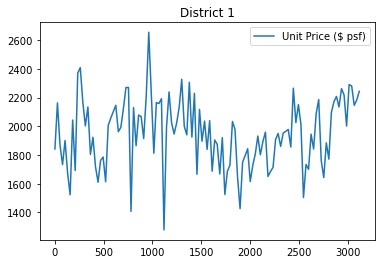

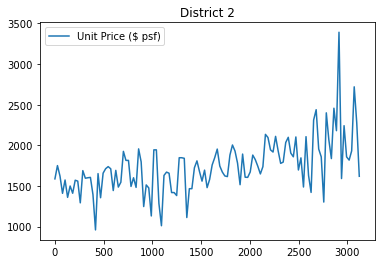

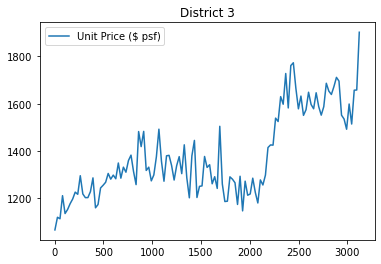

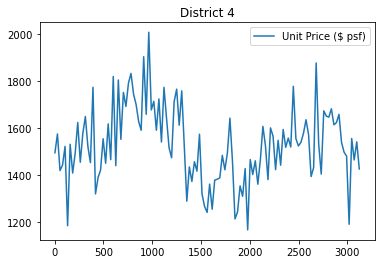

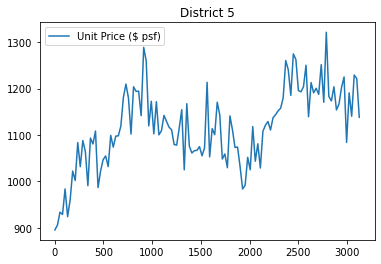

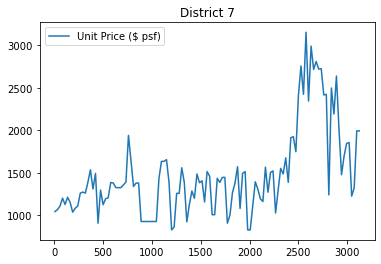

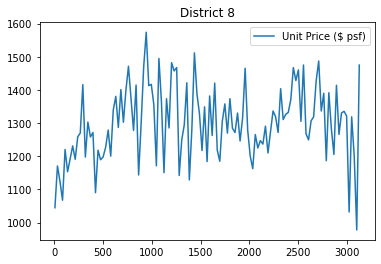

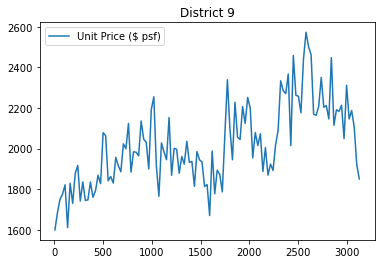

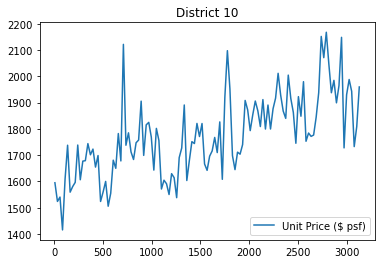

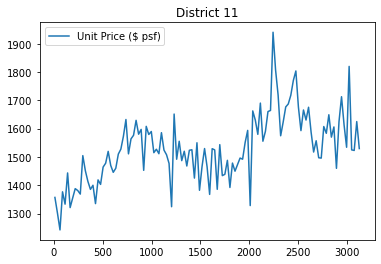

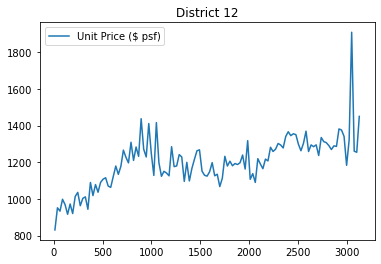

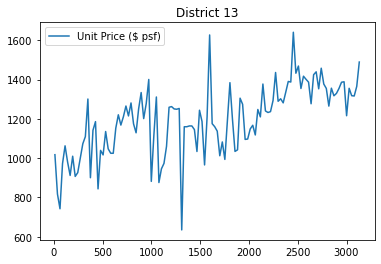

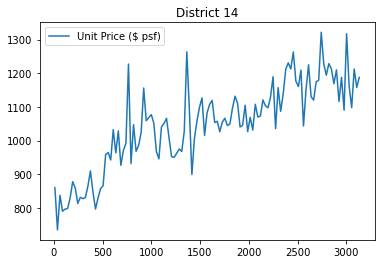

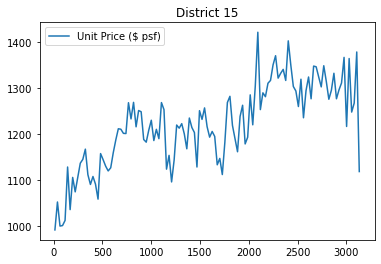

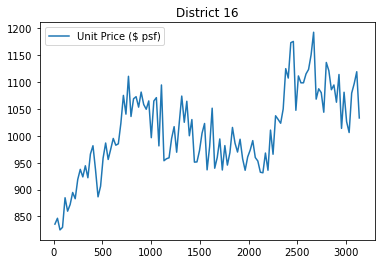

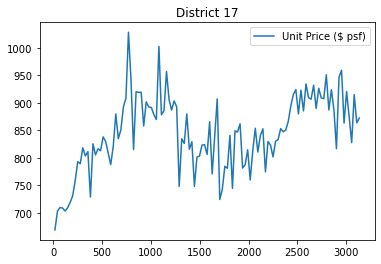

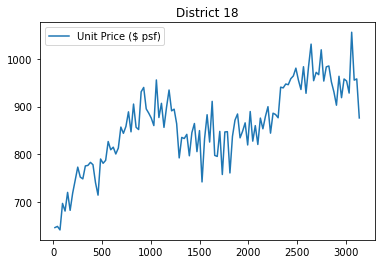

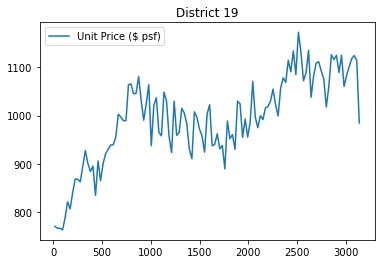

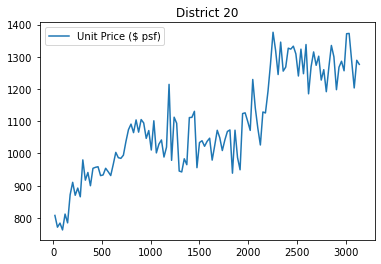

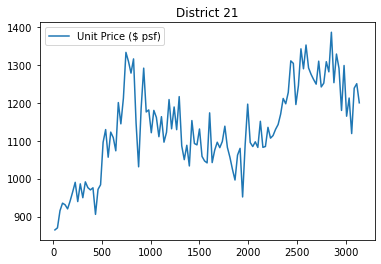

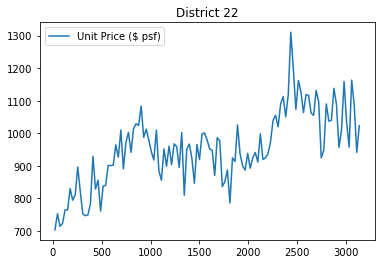

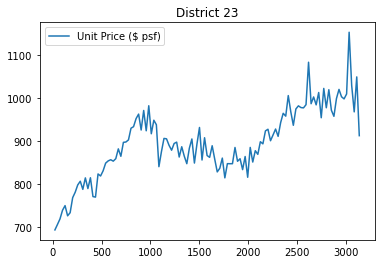

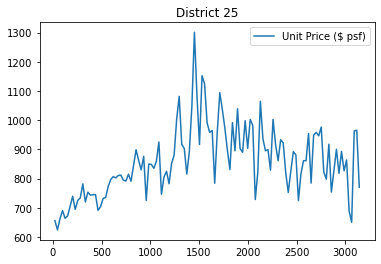

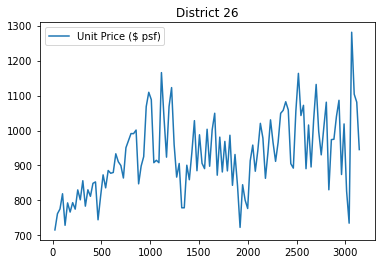

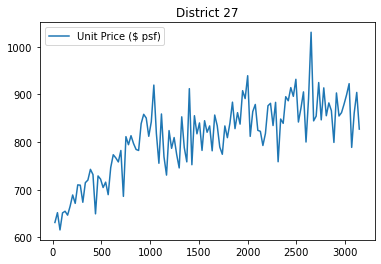

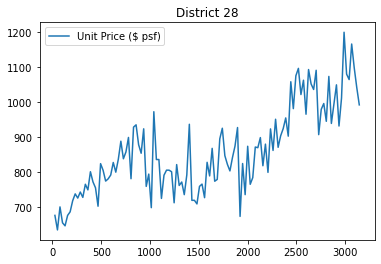

In [24]:
# Plot monthly average unit price of resale propertiesfor each district for past ten years
for i in [x for x in range(1,29) if x != 6 and x !=24]:
    Average_monthly_df_filled_resale.loc[(Average_monthly_df_filled_resale['Postal District'] == i)].plot(y='Unit Price ($ psf)')
    plt.title('District ' + str(i))
    plt.show()

In [25]:
#Add a column to store log_psf
Average_monthly_df_filled_resale.loc[ : , 'log_psf'] = np.log(Average_monthly_df_filled_resale['Unit Price ($ psf)'])
Average_monthly_df_filled_resale.head()

,Month_Year,Postal District,Unit Price ($ psf),log_psf
0,2010-09,1,1842.100000,7.518662
1,2010-09,2,1586.833333,7.369496
2,2010-09,3,1066.400000,6.972044
3,2010-09,4,1494.769231,7.309727
4,2010-09,5,895.509434,6.797393


In [26]:
# Print model summaries, plots, and prediction results for all districts except Distrct 6 & 24
districts_2 = []
MAPE_2 = []
percentage_change_2 = []
log_Predicted_2 = []
log_Currentprice_2 = []
for i in [x for x in range(1,29) if x != 6 and x !=24]:
        print('=============================Results of District', i,'============================')
        # train the model
        train_size = round(0.9 * len(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == i)]))
        test_size = round(0.1 * len(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == i)]))
        train = Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == i)][:train_size]
        test = Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == i)][train_size:]
        
        if len(train) >= 50:
            model = pm.auto_arima(train[(train['Postal District'] == i)]['log_psf'], suppress_warnings=True)
            print()
            temp = model.order
            p, d, q = temp[0], temp[1], temp[2]
            #print(model.plot_diagnostics())
            
            #model.resid()
            #plot_acf(model.resid(),lags=20)
            #plt.show()
            #plot_pacf(model.resid(),lags=20)
            #plt.show()
            
            pred = model.predict(test_size)
            Test = pd.DataFrame()
            Test['pred'] = list(pred)
            MAPE_i = mape(list(test['log_psf']), Test['pred'])
            
            model_p_resale = pm.auto_arima(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == i)]['log_psf'],suppress_warnings=True)
            #model_p = ARIMA(Average_monthly_df[(Average_monthly_df['Postal District'] == i)&(Average_monthly_df['Tenure_dummy(>900)'] == j)]['log_psf'],order=(p, d, q))
            pred_p_resale = model_p_resale.predict(36)
            print(model_p_resale.summary())
            print()
            # integrate the results
            districts_2.append(i)
            MAPE_2.append(MAPE_i)
            percentage_change_2.append(float(100*(pred_p_resale[-1:] - float(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == i)]['log_psf'][-1:]))) ) 
            log_Predicted_2.append(float(pred_p_resale[-1:]))
            log_Currentprice_2.append(float(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == i)]['log_psf'][-1:]))
                           
        else:
            pass

=============================Results of District 1 ============================

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  88.288
Date:                Sun, 04 Oct 2020   AIC                           -168.577
Time:                        21:02:34   BIC                           -157.394
Sample:                             0   HQIC                          -164.035
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.7472      1.857      1.479      0.139      -0.893       6.388
ar.L1          0.6369      0.245      2.595      0


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 200.605
Date:                Sun, 04 Oct 2020   AIC                           -395.210
Time:                        21:03:00   BIC                           -386.848
Sample:                             0   HQIC                          -391.814
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6894      0.096     -7.146      0.000      -0.879      -0.500
ma.L2          0.1300      0.101      1.293      0.196      -0.067       0.327
sigma2         0.0021      0.000      7.100      0.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 182.739
Date:                Sun, 04 Oct 2020   AIC                           -361.478
Time:                        21:03:19   BIC                           -355.903
Sample:                             0   HQIC                          -359.214
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7035      0.057    -12.381      0.000      -0.815      -0.592
sigma2         0.0028      0.000      9.181      0.000       0.002       0.003
Ljung-Box (Q):                       33.82   Jarque


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 214.879
Date:                Sun, 04 Oct 2020   AIC                           -425.758
Time:                        21:03:32   BIC                           -420.183
Sample:                             0   HQIC                          -423.494
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5302      0.074     -7.163      0.000      -0.675      -0.385
sigma2         0.0016      0.000      6.686      0.000       0.001       0.002
Ljung-Box (Q):                       30.88   Jarque


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 182.384
Date:                Sun, 04 Oct 2020   AIC                           -360.768
Time:                        21:03:56   BIC                           -355.193
Sample:                             0   HQIC                          -358.504
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5246      0.077     -6.855      0.000      -0.675      -0.375
sigma2         0.0028      0.000      8.328      0.000       0.002       0.003
Ljung-Box (Q):                       40.23   Jarque


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 180.000
Date:                Sun, 04 Oct 2020   AIC                           -350.000
Time:                        21:04:17   BIC                           -336.063
Sample:                             0   HQIC                          -344.340
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.003      1.606      0.108      -0.001       0.009
ar.L1         -0.3712      0.172     -2.159      0.031      -0.708      -0.034
ar.L2         -0.2266      0.141     -1.611      0.

In [27]:
Result_resale = pd.DataFrame({'district': districts_2, 'MAPE_resale': MAPE_2, 'log_Predicted': log_Predicted_2, 'log_Currentprice': log_Currentprice_2})
Result_resale['Predicted'] = np.exp(Result_resale['log_Predicted'])
Result_resale['Currentprice'] = np.exp(Result_resale['log_Currentprice'])
Result_resale['percentage_increase'] = Result_resale['Predicted'] / Result_resale['Currentprice'] - 1

In [28]:
Result_resale.sort_values('percentage_increase',ascending=False)

,district,MAPE_resale,log_Predicted,log_Currentprice,Predicted,Currentprice,percentage_increase
1,2,2.356959,7.734650,7.389255,2286.208453,1618.500000,0.412548
25,28,0.816297,7.110641,6.900328,1224.933081,992.600000,0.234065
17,19,0.510549,7.062730,6.892286,1167.628610,984.650000,0.185831
16,18,1.013939,6.939979,6.775366,1032.748821,876.000000,0.178937
18,20,0.518624,7.305020,7.151834,1487.749676,1276.444444,0.165542
21,23,0.617092,6.968269,6.816325,1062.382141,912.625000,0.164095
24,27,0.747008,6.850653,6.718107,944.497907,827.250000,0.141732
12,14,1.036005,7.197147,7.079858,1335.615194,1187.800000,0.124445
13,15,0.677026,7.122803,7.019535,1239.921091,1118.266667,0.108788
10,12,0.981370,7.363735,7.279112,1577.718035,1449.700000,0.088307


### Distrcit 2_Resale gives the best result, now focus on District 2_Resale property

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(3, 1, 1)   Log Likelihood                  54.358
Date:                Sun, 04 Oct 2020   AIC                            -96.717
Time:                        21:04:22   BIC                            -79.992
Sample:                             0   HQIC                           -89.924
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0035      0.001      3.486      0.000       0.002       0.006
ar.L1          0.0299      0.093      0.323      0.747      -0.152       0.211
ar.L2         -0.1170      0.091     -1.290      0.1

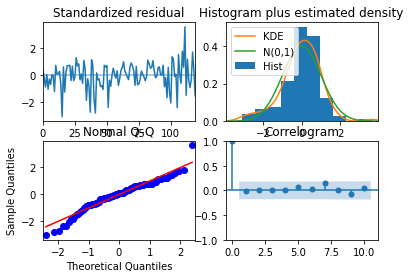

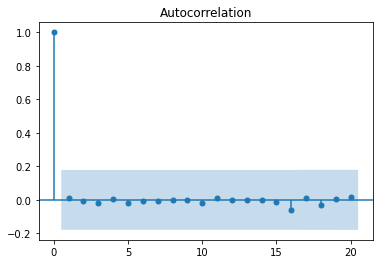

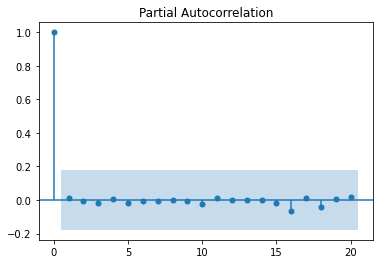

In [29]:
model_p_resale_2 = pm.auto_arima(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == 2)]['log_psf'],suppress_warnings=True)
print(model_p_resale_2.summary())
print(model_p_resale_2.plot_diagnostics())
# To check residual and any ARMA effect left
model_p_resale_2.resid()
plot_acf(model_p_resale_2.resid(),lags=20)
plt.show()
plot_pacf(model_p_resale_2.resid(),lags=20)
plt.show()

In [30]:
# Plot line chart for District 2_Resale property with historical and predict
model_p_resale_2 = pm.auto_arima(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == 2)]['log_psf'],suppress_warnings=True)
pred_p_resale_2, conf = model_p_resale_2.predict(36, return_conf_int=True,alpha=0.05)
print(pred_p_resale_2)
print(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == 2)]['log_psf'][-1:])

[7.57538216 7.64931942 7.68107367 7.65081729 7.63936205 7.64163551
 7.65080584 7.65594158 7.65822633 7.6599319  7.66251906 7.66559973
 7.66867312 7.67156502 7.67438321 7.67722147 7.68009437 7.68297629
 7.68585161 7.68872082 7.69158936 7.69445952 7.69733067 7.70020174
 7.70307248 7.70594307 7.70881371 7.71168441 7.71455513 7.71742584
 7.72029654 7.72316723 7.72603793 7.72890863 7.73177933 7.73465003]
3121    7.389255
Name: log_psf, dtype: float64


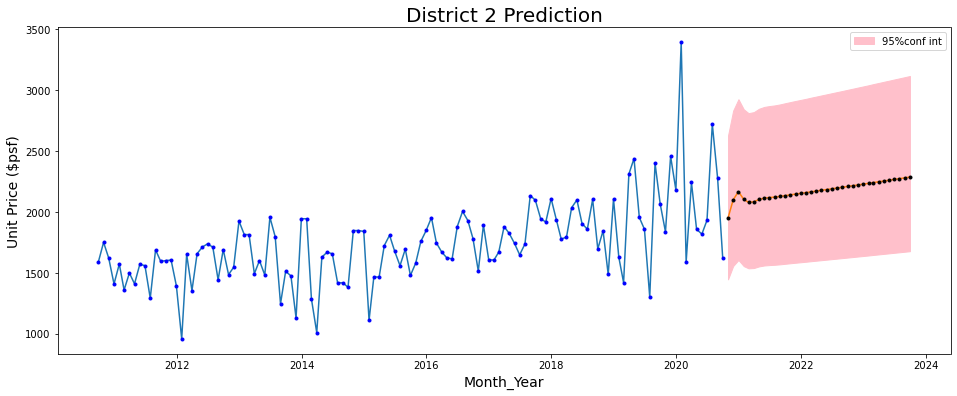

In [31]:
Test = pd.DataFrame()
Test['test_periods'] = pd.Series(pd.date_range('2020-10-01','2023-10-01', freq = 'M'))
Test['lower_bounds'] = [i[0] for i in conf ]
Test['upper_bounds'] = [i[1] for i in conf ]
Test['prediction'] = list(pred_p_resale_2)
    
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot_date( pd.Series(pd.date_range('2010-09-01','2020-10-01', freq = 'M')), Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == 2)]['Unit Price ($ psf)'],linestyle = 'solid',markeredgecolor = 'blue',markerfacecolor = 'blue', markersize = 3)
ax1.plot_date( Test['test_periods'], np.exp(Test['prediction']), linestyle = 'solid',markeredgecolor = 'black',markerfacecolor = 'black', markersize = 3)
plt.fill_between(Test['test_periods'], np.exp(Test['lower_bounds']), np.exp(Test['upper_bounds']), color='pink', label='95%conf int')
ax1.set_xlabel('Month_Year',fontsize=14)
ax1.set_ylabel('Unit Price ($psf)',fontsize=14)
plt.title('District 2 Prediction', size=20)
plt.legend()
plt.show() 

### We also want to know the transaction number in District 2 by full year

In [32]:
data['Year'] = pd.to_datetime(data['Sale Date']).dt.to_period('Y')

In [33]:
data['Year'].unique()

<PeriodArray>
['2012', '2011', '2010', '2015', '2014', '2013', '2020', '2019', '2018',
 '2017', '2016']
Length: 11, dtype: period[A-DEC]

In [34]:
#We only want District 2
district2 = data[data['Postal District'] == 2]

In [35]:
#We do not need 2020 since it is not full year
district2 = district2[district2['Year'] != '2020']

In [36]:
d2_by_year = district2['Year'].value_counts().sort_index()

<AxesSubplot:>

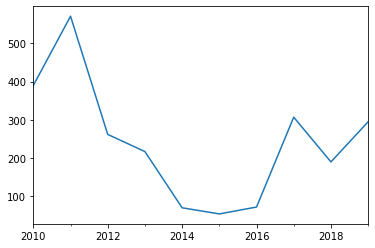

In [37]:
d2_by_year.plot()

#### One thing more: try to run Arima model using the absolute price, not the log price

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -843.597
Date:                Sun, 04 Oct 2020   AIC                           1699.194
Time:                        21:10:13   BIC                           1715.919
Sample:                             0   HQIC                          1705.986
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.8797      2.224      3.094      0.002       2.521      11.238
ar.L1         -0.0101      0.091     -0.111      0.912      -0.189       0.169
ar.L2         -0.0958      0.091     -1.058      0.2

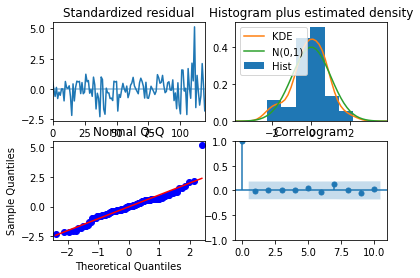

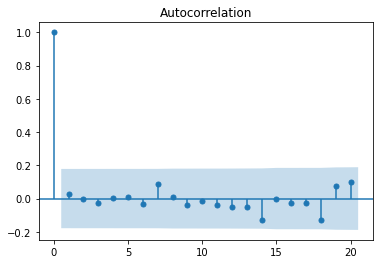

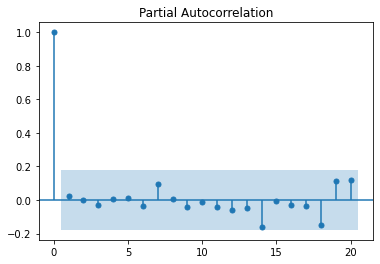

In [47]:
model_p_resale_v2 = pm.auto_arima(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == 2)]['Unit Price ($ psf)'],suppress_warnings=True)
print(model_p_resale_v2.summary())
print(model_p_resale_v2.plot_diagnostics())
# To check residual and any ARMA effect left
model_p_resale_v2.resid()
plot_acf(model_p_resale_v2.resid(),lags=20)
plt.show()
plot_pacf(model_p_resale_v2.resid(),lags=20)
plt.show()

In [48]:
pred_p_resale_v2, conf_v2 = model_p_resale_v2.predict(36, return_conf_int=True,alpha=0.05)
print(pred_p_resale_v2)
print(Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == 2)]['Unit Price ($ psf)'][-1:])

[1989.289883   2133.77584362 2219.91546809 2146.58871294 2120.43539384
 2119.39354192 2141.74103869 2153.11370478 2157.92056228 2159.71470207
 2164.10691945 2169.92124248 2176.00427901 2181.48943784 2186.70372032
 2191.93058387 2197.28887662 2202.69247598 2208.08079884 2213.44172131
 2218.79638304 2224.15643227 2229.52186642 2234.88783553 2240.25233161
 2245.61584024 2250.97940555 2256.34332509 2261.70741002 2267.07144931
 2272.43541066 2277.79934795 2283.16330102 2288.52727    2293.89124155
 2299.25520877]
3121    1618.5
Name: Unit Price ($ psf), dtype: float64


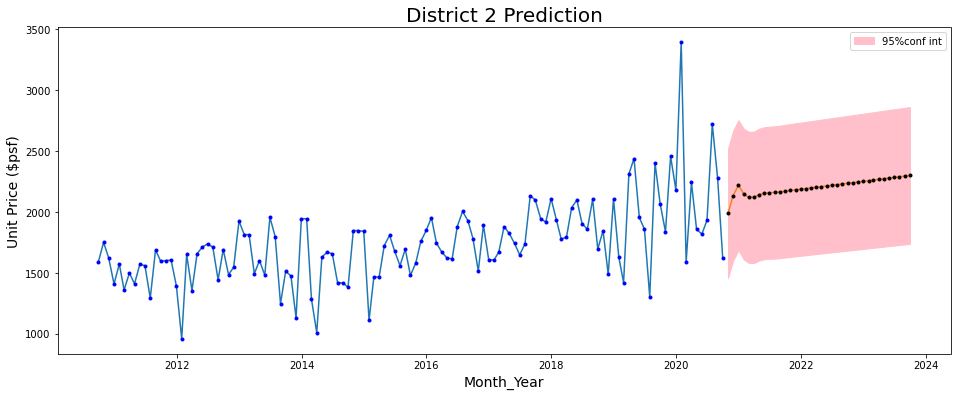

In [51]:
Test = pd.DataFrame()
Test['test_periods'] = pd.Series(pd.date_range('2020-10-01','2023-10-01', freq = 'M'))
Test['lower_bounds_2'] = [i[0] for i in conf_v2 ]
Test['upper_bounds_2'] = [i[1] for i in conf_v2 ]
Test['prediction_2'] = list(pred_p_resale_v2)
    
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot_date( pd.Series(pd.date_range('2010-09-01','2020-10-01', freq = 'M')), Average_monthly_df_filled_resale[(Average_monthly_df_filled_resale['Postal District'] == 2)]['Unit Price ($ psf)'],linestyle = 'solid',markeredgecolor = 'blue',markerfacecolor = 'blue', markersize = 3)
ax1.plot_date( Test['test_periods'], Test['prediction_2'], linestyle = 'solid',markeredgecolor = 'black',markerfacecolor = 'black', markersize = 3)
plt.fill_between(Test['test_periods'], Test['lower_bounds_2'],Test['upper_bounds_2'], color='pink', label='95%conf int')
ax1.set_xlabel('Month_Year',fontsize=14)
ax1.set_ylabel('Unit Price ($psf)',fontsize=14)
plt.title('District 2 Prediction', size=20)
plt.legend()
plt.show() 